In [430]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import re

from scipy.stats import norm, pearsonr, chi2_contingency, mode
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_auc_score, roc_curve, hamming_loss,precision_score,recall_score,f1_score

from confusion import make_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from to_img import to_img

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

%matplotlib inline

## 1. Data

The data consists of text scraped from every search result for 'data science/scientist' on Indeed.com using the [Requests](https://docs.python-requests.org/en/master/ "Requests Library"), Tor, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/ "BeautifulSoup") libraries.

### 1.1 Load and Inspect Table

In [431]:
# usecols is a memory saver. The entire table is in the low gigabytes, largly because I'm saving the raw HTML each record is derived from.
cols = ['rating', 'company', 'title', 'location', 'extractDate', 'postDate', 'requirements', 'description', 'summary', 'salary', 'estimated_salary', 'url']
#data = pd.read_csv('../app/data/total.csv',usecols=cols)
data = pd.read_csv('../app/data/total.csv',usecols=cols)
print(len(data))
data.info(memory_usage='deep')
data.head(3)

11023
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11023 entries, 0 to 11022
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           11023 non-null  object 
 1   description       11023 non-null  object 
 2   estimated_salary  3666 non-null   object 
 3   extractDate       11023 non-null  object 
 4   location          11023 non-null  object 
 5   postDate          11023 non-null  object 
 6   rating            8707 non-null   float64
 7   requirements      739 non-null    object 
 8   salary            7422 non-null   object 
 9   summary           11023 non-null  object 
 10  title             11023 non-null  object 
 11  url               11023 non-null  object 
dtypes: float64(1), object(11)
memory usage: 102.5 MB


,company,description,estimated_salary,extractDate,location,postDate,rating,requirements,salary,summary,title,url
0,Northrop Grumman,Requisition ID: R10053754Category: Engineering...,NaN,2022-07-20,"Huntsville, AL",PostedToday,4.0,NaN,"$71,100 - $138,400 a year","Support the design, develop, and document the ...",Sentinel (GBSD) Software Engineer/Data Scienti...,https://www.indeed.com/rc/clk?jk=b2d23fef7cf5a...
1,AL2S3 LTD,Job Description An award-winning lobal early ...,"['', 'Not provided by employer', ""$114K - $145...",2022-07-20,United States,PostedPosted 1 day ago,NaN,NaN,NaN,"Manipulate, summarise and analyse clinical tri...",Senior Statistician,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,Bigbear.ai,Overview: BigBear.ai is seeking a Data Mana...,"['', 'Not provided by employer', ""$102K - $129...",2022-07-20,"Montgomery, AL 36114",PostedPosted 1 day ago,4.8,NaN,Full-time,"Federal Government, as well as customers in th...",Data Manager III,https://www.indeed.com/rc/clk?jk=2384cca332c13...


The table above is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.




In [432]:
# check for missing
print(data.isna().sum().sort_values(ascending=False))
data.description.dropna(axis=0, inplace=True)


requirements        10284
estimated_salary     7357
salary               3601
rating               2316
company                 0
description             0
extractDate             0
location                0
postDate                0
summary                 0
title                   0
url                     0
dtype: int64


In [433]:
# check for duplcates.
dupes = data.duplicated()
print(f'Number of dupes: {sum(dupes)}')


#data.drop_duplicates(inplace=True)

# renaming columns
data.columns = map(str.lower, data.columns)
data = data.rename({'title': 'job_title'}, axis=1)

Number of dupes: 8302


The likelihood of seeing duplicates coming from the raw scrapping is very unlikely, but this is still a good check to do in case something changes with Indeed.com's front-end code.

In [434]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11023 entries, 0 to 11022
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           11023 non-null  object 
 1   description       11023 non-null  object 
 2   estimated_salary  3666 non-null   object 
 3   extractdate       11023 non-null  object 
 4   location          11023 non-null  object 
 5   postdate          11023 non-null  object 
 6   rating            8707 non-null   float64
 7   requirements      739 non-null    object 
 8   salary            7422 non-null   object 
 9   summary           11023 non-null  object 
 10  job_title         11023 non-null  object 
 11  url               11023 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.0+ MB


Missing values are another story. It seems that Indeed.com doesn't require employers to provide values for every feature, this certainly seems to be the case with requirements, not to mention everywhere salary information coud be held.\
Others, like estimated salary and ratings are generated by Indeed.com but don't exist for every posting.\
job_type_items and salary_and_jType will likely be collapsed into a new column for job types, I'll also do the same with all of the salary related features to build the model's target.

### 1.1 Diagnose Data
In order to proceed with any statistical or exploratory data analysis I will need to wrangle the data quite a bit.
Here, I'll list each of the current feature columns and briefly describe what I'll need to do with them.

Column Groups and Needs
Simple
Salary
Text
etc

#### 1.2 Features


#### Data Dictionary

<style>
td, th {
   border: none!important;
}
</style>


| Feature      | Description 
|  :----:       |    :---   |
| rating   | Indeed.com ascribed company ratings        |
| company      | name of company       |
| location   | state and city/remote        |
| **Date Information**      |
| extractDate   | date record was webscrapped        |
| postDate   | date job posting was created        |
| **Descriptive Text**      |
| title   | job position title        |
| requirements   | employer-listed educational, aptitudes, and experience requirements        |
| summary   | brief summaries of each job extracted from sach results        |
| description   | full text description of job        |
| **Salary Information**      |
| sal_guide_items   | formatted list containing redundant characters and the Indeed salary estimate        |
| salary   | if given by employer        |
| salary_and_jType   | formatted list combining salary from salfromsection and job_type_items        |
| salfromsection   | salary, if given, extracted from job description        |
| estimated_salary   | Indeed's salary estimationname of company        |
| **etc.**      |
| raw_desc_soup   | raw full description, retained for possible future use/analysis        |
| job_type_items   | formatted list of 'full-time', 'part-time', etc        |
| url   | url of postings specific web page on Indeed.com        |

In [435]:
# check for missing
print(data.isna().sum().sort_values(ascending=False))

requirements        10284
estimated_salary     7357
salary               3601
rating               2316
company                 0
description             0
extractdate             0
location                0
postdate                0
summary                 0
job_title               0
url                     0
dtype: int64


In [436]:
data.nunique().sort_values(ascending=False)

url                 2472
summary              689
description          539
location             537
company              384
job_title            372
estimated_salary     194
salary               128
requirements          36
rating                27
postdate               6
extractdate            3
dtype: int64

In [437]:
data.describe(include='all')

,company,description,estimated_salary,extractdate,location,postdate,rating,requirements,salary,summary,job_title,url
count,11023,11023,3666,11023,11023,11023,8707.000000,739,7422,11023,11023,11023
unique,384,539,194,3,537,6,NaN,36,128,689,372,2472
top,KPMG,The KPMG Advisory practice is currently our fa...,"['', 'Not provided by employer', ""$114K - $145...",2022-07-19,United States,PostedToday,NaN,Bachelor's (Required)US work authorization (Re...,Full-time,"Analyze structured and unstructured data, unde...",Data Scientist,https://www.indeed.com/rc/clk?jk=920c25011a399...
freq,738,326,237,5792,386,5809,NaN,137,4041,322,1025,111
mean,NaN,NaN,NaN,NaN,NaN,NaN,3.800287,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,0.447490,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.600000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.900000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN


##### 1.2a Rating

As the only feature coming in with numeric (float) values I should just need to scale it. I'll address missing values by imputing zero. The rationale behind this is that an unrated company should simply be rated as zero.
print(sorted(data.rating.unique()))

'rating'\
Roughly a third of the data is missing values for the company rating feature. At first I used np.fillna(0) to imput 0 for all the missing values but that sharply right-skewed the distribution towards zero.\
Then I checked is scaling the data would fix the bi-modality but I think I have two options here, drop all those records or drop a potentially valuable feature.\
For now, I'll drop the records, I can always get more, and in the future I could conduct linear regression to imput the values.

In [438]:
def featureReport(data,feature):
    """Returns summary information for a given feature.

    Args:
        data (DataFrame): data collection
        feature (DataFrame): particular feature identifier
    """
    data_len = len(data)
    missing_len = len(data[data[feature].isna()])
    print(f'-- {feature} report --')
    if missing_len > 0:
        print(f'Missing {missing_len} out of {data_len} Records')
        print(f'Percent Missing: {round((missing_len/data_len)*100,1)}%')
    else:
        print('Nothing Missing')
        print(f'Records: {data_len}')
    
    print(f'Unique Values: {len(data[feature].unique())}')

    notna = data[feature].notna()

    if (data[feature].dtype != (object)) and feature !='dateposted':

        mini = np.min(data[notna][feature])
        if mini != None:
            print(f'Min: {round(mini,4)}')

        maxi = np.max(data[notna][feature])
        if maxi != None:
            print(f'Max: {round(maxi,4)}')

        mean = np.mean(data[notna][feature])
        if mean != None:
            print(f'Mean: {round(mean,4)}')

        mode_ = mode(data[notna][feature])[0][0]
        if mode_ != None:
            print(f'Mode: {round(mode_,4)}')

        std = np.std(data[notna][feature])
        if std != None:
            print(f'Std.Dev: {round(std,4)}')
        #Percentage=(missing_len/len_data)*100


featureReport(data, feature = 'rating')

-- rating report --
Missing 2316 out of 11023 Records
Percent Missing: 21.0%
Unique Values: 28
Min: 1.0
Max: 5.0
Mean: 3.8003
Mode: 3.9
Std.Dev: 0.4475


For now I'll drop these. I'm considering what and how to impute. What I'd like to do is run clustering on the data, or perhaps logistic regression. One thing I know is that the picture will become clearer as I gain more data. For now though, the amount of missing values is very small.

In [439]:
data[data['rating'].isnull()] == 0
print(len(data))

11023


outliers

In [440]:
outliers = []
def z_detect(data, feature):
    sample = data[feature]
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return sorted(outliers)
        
z = z_detect(data, feature = 'rating')
data.loc[data['rating'].isin(z)][:].rating.value_counts()


1.0    50
Name: rating, dtype: int64

In [441]:
data.loc[data['rating'].isin(z)].head(3)

,company,description,estimated_salary,extractdate,location,postdate,rating,requirements,salary,summary,job_title,url
4146,"MSi Workforce Solutions, LLC",Title: Sr. Systems Analyst (Data Analyst)Loca...,"['', 'Not provided by employer', ""$95K - $120K...",2022-07-20,"Chattanooga, TN 37421",PostedPosted 2 days ago,1.0,SQL: 5 years (Required),Full-time,Experience with data analytics and data insigh...,Sr Systems Analyst/Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
4155,"MSi Workforce Solutions, LLC",Title: Sr. Systems Analyst (Data Analyst)Loca...,"['', 'Not provided by employer', ""$95K - $120K...",2022-07-20,"Chattanooga, TN 37421",PostedPosted 2 days ago,1.0,SQL: 5 years (Required),Full-time,Experience with data analytics and data insigh...,Sr Systems Analyst/Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
4163,"MSi Workforce Solutions, LLC",Title: Sr. Systems Analyst (Data Analyst)Loca...,"['', 'Not provided by employer', ""$95K - $120K...",2022-07-20,"Chattanooga, TN 37421",PostedPosted 2 days ago,1.0,SQL: 5 years (Required),Full-time,Experience with data analytics and data insigh...,Sr Systems Analyst/Data Analyst,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


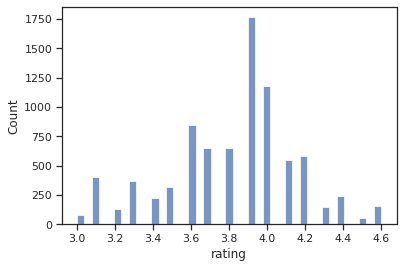

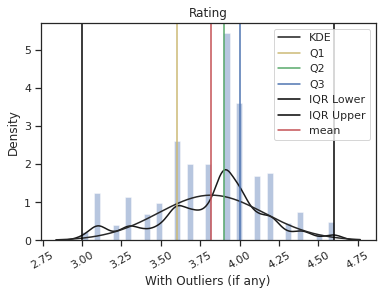

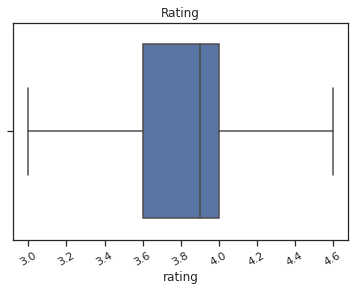

There are 0 records below and 0 above.
Records Including Outliers: 8327
Records Without Outliers: 8327


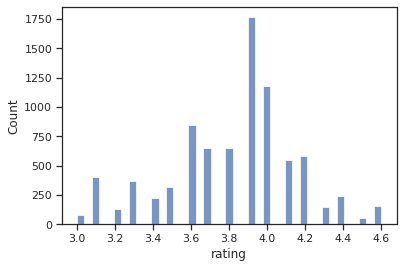

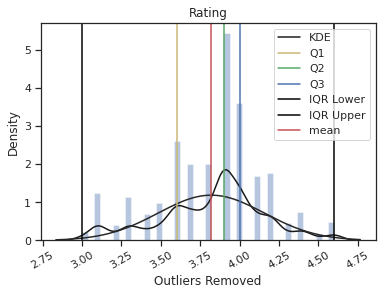

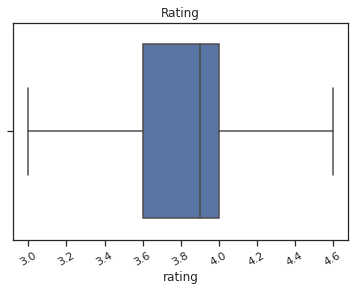

-- rating report --
Nothing Missing
Records: 8327
Unique Values: 17
Min: 3.0
Max: 4.6
Mean: 3.8199
Mode: 3.9
Std.Dev: 0.3358


In [469]:
def iqr_detect(data, feature):
    """takes data, selects particular feature, analyses outliers using IQR method, then trims out data that contains detected outliers

    Args:
        data (Dataframe): data
        feature (string): identifier for particular feature

    Returns:
        sns plots and a DataFrame: pre and post outlier trimming plots
    """
    # plotting
    def plotting(axlabel_):
        """provides pre and post outlier trimming plots

        Args:
            axlabel_ (string): permits ax label to be passed as an arguement at each function call
        """

        # histogram
        sns.histplot(data[feature])
        plt.show()

        # distribution plot
        sns.distplot(data[feature], fit=norm, kde=True, kde_kws={'color': 'k', 'label': 'KDE', }, axlabel=axlabel_)
        

        plt.axvline(x=q1, label='Q1', c = 'y')
        plt.axvline(x=q2, label='Q2', c = 'g')
        plt.axvline(x=q3, label='Q3', c = 'b')

        plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
        plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
        plt.axvline(x=np.mean(data[feature]), label='mean', c = 'r')

        plt.xticks(rotation=30)
        plt.title(f'{feature.capitalize()}')
        plt.legend()
        plt.show()

        # boxplot
        sns.boxplot(data=data, x=feature)
        plt.xticks(rotation=30)
        plt.title(f'{feature.capitalize()}')
        plt.show()



    q1 = np.quantile(data[data[feature].notna()][feature], 0.25)
    q2 = np.quantile(data[data[feature].notna()][feature], 0.5)
    q3 = np.quantile(data[data[feature].notna()][feature], 0.75)

    # calc iqr
    iqr = (q3 - q1)
    # expand iqr to discern outliers
    iqr_x = iqr*1.5
    # setting the lower and upper limits
    iqr_lower = q1-iqr_x
    iqr_upper = q3+iqr_x
    plotting(axlabel_='With Outliers (if any)')
    # report
    print(f'There are {len(data[data[feature] > iqr_upper])} records below and {len(data[data[feature] < iqr_lower])} above.')
    # trimming outliers
    '''
    trimmed = data[data[feature] > iqr_upper]
    trimmed = data[data[feature] < iqr_lower]
    '''
    print(f'Records Including Outliers: {len(data)}')
    data = data[data[feature] <= iqr_upper]
    data = data[data[feature] >= iqr_lower]
    print(f'Records Without Outliers: {len(data)}')

    plotting(axlabel_='Outliers Removed')
    
    return data, q1, q3

"""
       
    else:
        q1 = np.quantile(data[data[feature].notna()][feature], 0.25)
        q2 = np.quantile(data[data[feature].notna()][feature], 0.5)
        q3 = np.quantile(data[data[feature].notna()][feature], 0.75)


        # calc iqr
        iqr = (q3 - q1)

        # expand iqr to discern outliers
        iqr_x = iqr*1.5

        # setting the lower and upper limits
        iqr_lower = q1-iqr_x
        iqr_upper = q3+iqr_x
        plotting(axlabel_='With Outliers (if any)')
        print(f'There are {len(data[data[feature] > iqr_upper])} records below and {len(data[data[feature] < iqr_lower])} above.')

        print(f'Records Including Outliers: {len(data)}')
        data = data[data[feature].notna() <= iqr_upper]
        data = data[data[feature].notna() >= iqr_lower]
        print(f'Records Without Outliers: {len(data)}')
        print('hi')
        plotting(axlabel_='Outliers Removed')
"""

    


data, q1, q3 = iqr_detect(data, feature='rating')
featureReport(data, feature = 'rating')

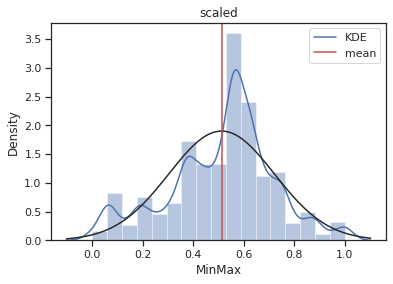

-- rating report --
Nothing Missing
Records: 8327
Unique Values: 17
Min: 0.0
Max: 1.0
Mean: 0.5124
Mode: 0.5625
Std.Dev: 0.2099


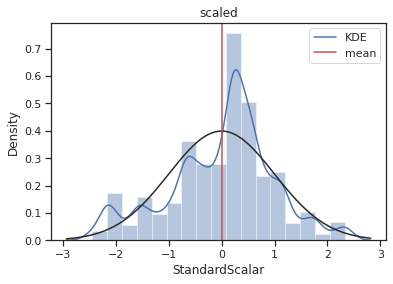

-- rating report --
Nothing Missing
Records: 8327
Unique Values: 17
Min: -2.4412
Max: 2.3229
Mean: 0.0
Mode: 0.2386
Std.Dev: 1.0


In [443]:
# The below is a preview of how this feature will be shaped with a given slaing method to be used in the preprocessing piepline
scalar = MinMaxScaler()
minmax_scaled_ratings = pd.DataFrame(scalar.fit_transform(pd.DataFrame(data.rating)), columns=['rating'])
sns.distplot(minmax_scaled_ratings, fit=norm, bins=minmax_scaled_ratings.rating.nunique(), kde=True, kde_kws={'color': 'b', 'label': 'KDE'}, axlabel='MinMax')
plt.title('scaled')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(minmax_scaled_ratings.rating), label='mean', c = 'r')
plt.legend()
plt.show()
featureReport(minmax_scaled_ratings, feature = 'rating')



scalar = StandardScaler()
standard_scaled_ratings = pd.DataFrame(scalar.fit_transform(pd.DataFrame(data.rating)), columns=['rating'])
sns.distplot(standard_scaled_ratings, fit=norm, bins=minmax_scaled_ratings.rating.nunique(), kde=True, kde_kws={'color': 'b', 'label': 'KDE'}, axlabel='StandardScalar')
plt.title('scaled')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(standard_scaled_ratings.rating), label='mean', c = 'r')
plt.legend()
plt.show()
featureReport(standard_scaled_ratings, feature = 'rating')


I'm going to run a few tests to see which scaling is best. I suspect it will fall on standard deviation, which for MinMax is tighter. Other than that I'm pleased with how this feature has been preprocessed.<br>\
For further analysis I'd like to analyze the trends in who's hiring:
- the trends of each of my four target-associated sub-populations.
- which companies are going big.
- historical, weekly, monly, annually even - this could be a backdoor into stock market and company valuation analysis.

In [444]:
# Companies that share the mode as their rating
data[data.rating == mode(data.rating)[0][0]].company.value_counts()[:5]

KPMG                         738
IBM                          216
Navy Federal Credit Union    110
Expedia Group                 95
Vail Resorts                  67
Name: company, dtype: int64

##### 1.2a Dates

'extractdate' & 'postdate'\
extract_date is a string showing the day the record was webscrapped.
post_date is a string description of the relative age of each post from the date it was posted to the day it was webscrapped.
Converting post_date to a number will give me the the posts ae, which I'll then subtract from it's extract date in order to build a new feature carrying values for the DATE each job posting has been submitted to Indeed.com.

The extractdate is the value given by my parser representing the date the data was pulled from Indeed.com.\
The postdate is how many days have passed since the post was made and when the search was conducted (by my webscraper).\
The task is to find the delta (difference), the intervening days since the post was made, and subtract it from the extract date so I can get the actual date publishd.

-- extractdate report --
Nothing Missing
Records: 8327
Unique Values: 3

-- postdate report --
Nothing Missing
Records: 8327
Unique Values: 5



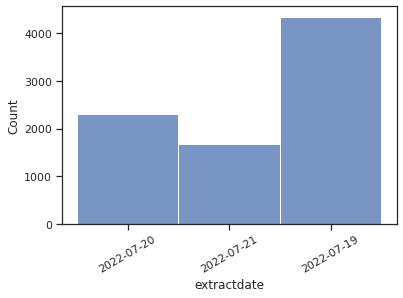

,extractdate,postdate
0,2022-07-20,PostedToday
4,2022-07-20,PostedPosted 3 days ago
7,2022-07-20,PostedToday
8,2022-07-20,PostedPosted 1 day ago
12,2022-07-20,PostedToday


In [445]:
features = data[['extractdate', 'postdate']].columns

for feature_ in features:
    featureReport(data, feature = feature_)
    print('')

#plt.title('extractdate ')
sns.histplot(data['extractdate'])
plt.xticks(rotation=30)
plt.show()


data[['extractdate', 'postdate']].head()

In [446]:
def postD(row):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.
    Args:
        data (string): text descrption of how old the post is.
    Returns:
        npnan or int: numeric representation of post age
    """
    if row['postdate'] != np.nan:
        if row['postdate'] in ['PostedToday', 'PostedJust posted', 'Hiring ongoing']:
            delta = timedelta(0)
        elif row['postdate'] in ['PostedPosted 1 day ago', 'Posted1 day ago']:
            delta = timedelta(1)
        elif row['postdate'] in ['PostedPosted 2 days ago', 'Posted2 day ago']:
            delta = timedelta(2)
        elif row['postdate'] in ['PostedPosted 3 days ago', 'Posted3 day ago']:
            delta = timedelta(3)
        value = pd.to_datetime(row['extractdate'])-delta
    return value



data['dateposted'] = data.apply( lambda row : postD(row), axis = 1)
print(featureReport(data, feature = 'extractdate'),'\n')
print(featureReport(data, feature = 'postdate'),'\n')
print(featureReport(data, feature = 'dateposted'),'\n')
data[['extractdate', 'postdate','dateposted']].head()

-- extractdate report --
Nothing Missing
Records: 8327
Unique Values: 3
None 

-- postdate report --
Nothing Missing
Records: 8327
Unique Values: 5
None 

-- dateposted report --
Nothing Missing
Records: 8327
Unique Values: 6
None 



,extractdate,postdate,dateposted
0,2022-07-20,PostedToday,2022-07-20
4,2022-07-20,PostedPosted 3 days ago,2022-07-17
7,2022-07-20,PostedToday,2022-07-20
8,2022-07-20,PostedPosted 1 day ago,2022-07-19
12,2022-07-20,PostedToday,2022-07-20


Even though it's not being used directly in my analysis, for now - I would like to find play with time series and seasonality. There's a pairplot in the multivariate analysis section that illustrates what I'm detecting in the data, a hump in the midweek.

#### Company & Job Title

In [447]:

str_features = data[['company','job_title']]
for feature in str_features.columns:
    print(featureReport(data, feature = feature),'\n')
    
data[['company','job_title']].head()

-- company report --
Nothing Missing
Records: 8327
Unique Values: 264
None 

-- job_title report --
Nothing Missing
Records: 8327
Unique Values: 293
None 



,company,job_title
0,Northrop Grumman,Sentinel (GBSD) Software Engineer/Data Scienti...
4,CyberCoders,"Senior ML Engineer - Stealth, Fully Funded (50..."
7,Walmart,(USA) Senior Data Analyst
8,Simmons Bank,Senior Data Analyst
12,Deloitte,"Senior Data Scientist, Experience Management"


Requirements do exist, but values are extremeley sparse. I'm keen to run NLP on this feature alone, encoding new features that are more or less associated with the target.


In [448]:
def cleanText_comp_jtitle(sentence):
    """clean the string of any punctuation or special characters

    Args:
        sentence (string): dirty string

    Returns:
        string: clean string
    """
    #function to 
    cleaned = sentence.replace('AI/ML','artificial intelligence machine learning')
    cleaned = cleaned.replace('AI','artificial intelligence')
    cleaned = cleaned.replace('ML','machine learning')
    cleaned = cleaned.replace('Sr.','senior')
    cleaned = cleaned.lower()
    cleaned = re.sub(r'[^a-zA-Z0-9 \n\.|.]+', r'', cleaned)
    cleaned = cleaned.replace('  ',' ')
    return cleaned

str_features = data[['company','job_title']]
for i in str_features.columns:
    data[i] = data[i].apply(cleanText_comp_jtitle)


for i in str_features.columns:
    print(featureReport(data, feature = i),'\n')
str_features.head(5)

-- company report --
Nothing Missing
Records: 8327
Unique Values: 263
None 

-- job_title report --
Nothing Missing
Records: 8327
Unique Values: 287
None 



,company,job_title
0,Northrop Grumman,Sentinel (GBSD) Software Engineer/Data Scienti...
4,CyberCoders,"Senior ML Engineer - Stealth, Fully Funded (50..."
7,Walmart,(USA) Senior Data Analyst
8,Simmons Bank,Senior Data Analyst
12,Deloitte,"Senior Data Scientist, Experience Management"


In [449]:
print('All Time Top Employers' + "\n\n" + f'{data.company.value_counts()[:10]}')
print('Most Frequently Observed Job Titles' + "\n\n" + f'{data.job_title.value_counts()[:10]}')

All Time Top Employers

kpmg                                  738
accenture                             357
deloitte                              245
ibm                                   216
jpmorgan chase bank n.a.              214
cybercoders                           201
spectrum                              199
logic2020 inc.                        184
infinity consulting solutions inc.    157
intuit                                155
Name: company, dtype: int64
Most Frequently Observed Job Titles

data scientist                                                                 762
senior data analyst                                                            427
lead specialist data scientist                                                 326
data scientist 4418074                                                         323
senior data scientist                                                          289
senior data scientist experience management                                 

#### Location

In [450]:
def cleanText_loc(row):
    """extracts, splits, and reassigns vaues from the location value in each row of data

    Args:
        row (string): row in the DataFrame

    Returns:
        DataFrame: row with location information assigned to new features, state, city, and remote status
    """
    #function to clean the word of any punctuation or special characters
    states = [', AK', 'Alaska', ', AL', 'Alabama', ', AR', 'Arkansas', ', AZ', 'Arizona', ', CA', 'California', ', CO', 'Colorado', ', CT', 'Connecticut', ', DC', 'District of Columbia', ', DE', 'Delaware', ', FL', 'Florida', ', GA', 'Georgia', ', HI', 'Hawaii', ', IA', 'Iowa', ', ID', 'Idaho', ', IL', 'Illinois', ', IN', 'Indiana', ', KS', 'Kansas',
 ', KY', 'Kentucky', ', LA', 'Louisiana', ', MA', 'Massachusetts', ', MD', 'Maryland', ', ME', 'Maine', ', MI', 'Michigan', ', MN', 'Minnesota', ', MO', 'Missouri', ', MS', 'Mississippi', ', MT', 'Montana', ', NC', 'North Carolina', ', ND', 'North Dakota', ', NE', 'Nebraska', ', NH', 'New Hampshire', ', NJ', 'New Jersey', ', NM', 'New Mexico',
 ', NV', 'Nevada', ', NY', 'New York', ', OH', 'Ohio', ', OK', 'Oklahoma', ', OR', 'Oregon', ', PA', 'Pennsylvania', ', RI', 'Rhode Island', ', SC', 'South Carolina', ', SD',
 'South Dakota', ', TN', 'Tennessee', ', TX', 'Texas', ', UT', 'Utah', ', VA', 'Virginia', ', VT', 'Vermont', ', WA', 'Washington', ', WI', 'Wisconsin', ', WV', 'West Virginia',
 ', WY', 'Wyoming']

    for i in states:
        if i in row['location']:
            row['state'] = i.strip(',')
        if ',' in row['location']:
            row['city'] = row['location'].split(',')[0].replace('Remote in ','')
            #row['city'] = row['city'].replace('Hybrid','')
            row['city'] = row['city'].replace('remote in ','').strip()
    



    if 'Hybrid remote' in row['location']:
        row['remote'] = 'Hybrid'

    elif 'remote in ' in row['location']:
        row['remote'] = 'Remote in'
    elif ('Remote' or 'remote') in row['location']:
        row['remote'] = 'Remote'
    else:
        row['remote'] = 'Not Remote'

    return row

data = data.copy()
data['remote'] = ''
data['state'] = ''
data['city'] = ''
data = data.apply( lambda row : cleanText_loc(row), axis = 1)


str_features = ['location','state','city','remote']

for i in str_features:
    print(featureReport(data, feature = i),'\n')


data[str_features].head(5)


-- location report --
Nothing Missing
Records: 8327
Unique Values: 436
None 

-- state report --
Nothing Missing
Records: 8327
Unique Values: 62
None 

-- city report --
Nothing Missing
Records: 8327
Unique Values: 219
None 

-- remote report --
Nothing Missing
Records: 8327
Unique Values: 3
None 



,location,state,city,remote
0,"Huntsville, AL",AL,Huntsville,Not Remote
4,"Huntsville, AL 35801",AL,Huntsville,Not Remote
7,"Bentonville, AR 72712",AR,Bentonville,Not Remote
8,"Little Rock, AR 72201 (Downtown CBD area)",AR,Little Rock,Not Remote
12,"Phoenix, AZ 85012 (Encanto area)",AZ,Phoenix,Not Remote


#### descriptive text

In [451]:
str_features = data[['description','summary','requirements']]
for i in str_features.columns:
    print(featureReport(data, feature = i),'\n')
str_features.head(5)

-- description report --
Nothing Missing
Records: 8327
Unique Values: 403
None 

-- summary report --
Nothing Missing
Records: 8327
Unique Values: 513
None 

-- requirements report --
Missing 8110 out of 8327 Records
Percent Missing: 97.4%
Unique Values: 14
None 



,description,summary,requirements
0,Requisition ID: R10053754Category: Engineering...,"Support the design, develop, and document the ...",NaN
4,"Senior ML Engineer - Stealth, Fully Funded (5...",Online (real-time) and offline data collection...,NaN
7,Position Summary...What you'll do... Data Sour...,Adopts a broad perspective that considers data...,NaN
8,Position SummaryThe Data Analyst IV position i...,The Data Analyst IV position involves the proc...,NaN
12,"In today's world, customers expect companies ...",A Master's in a quantitative field (engineerin...,NaN


In [452]:
len(data)
data.dropna(subset=['description'], inplace=True)
len(data)

8327

In [453]:

def cleanText_descriptive(row):

    summary = row['summary']
    description = row['description']
    requirements = row['requirements']

    text = summary+' '+description
    if type(requirements) != type(np.nan):
        text = requirements+' '+text
    
    sentences = text.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r' ',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r' ',clean_sentence)
        # TODO when seperating ut requirements for aalysis you can use this string but add 0-9 to retain numbers, like years exp.
        clean_sentence = " ".join(re.findall("[(a-zA-Z,&)]+", clean_sentence))
        clean_sentences.append(clean_sentence)
    clean_text = ''
    for i in clean_sentences:
        clean_text+=' '
        clean_text+=i
        clean_text = clean_text.strip().lower()
    row['text'] =  clean_text
    return row


data = data.copy()
data['text'] = ''
data = data.apply( lambda row : cleanText_descriptive(row), axis = 1)


In [454]:


str_features = data[['description', 'summary', 'requirements', 'text']]
for i in str_features.columns:
    print(featureReport(data, feature = i),'\n')
str_features.head(5)


-- description report --
Nothing Missing
Records: 8327
Unique Values: 403
None 

-- summary report --
Nothing Missing
Records: 8327
Unique Values: 513
None 

-- requirements report --
Missing 8110 out of 8327 Records
Percent Missing: 97.4%
Unique Values: 14
None 

-- text report --
Nothing Missing
Records: 8327
Unique Values: 533
None 



,description,summary,requirements,text
0,Requisition ID: R10053754Category: Engineering...,"Support the design, develop, and document the ...",NaN,support the design develop and document the da...
4,"Senior ML Engineer - Stealth, Fully Funded (5...",Online (real-time) and offline data collection...,NaN,online real time and offline data collection f...
7,Position Summary...What you'll do... Data Sour...,Adopts a broad perspective that considers data...,NaN,adopts a broad perspective that considers data...
8,Position SummaryThe Data Analyst IV position i...,The Data Analyst IV position involves the proc...,NaN,the data analyst iv position involves the proc...
12,"In today's world, customers expect companies ...",A Master's in a quantitative field (engineerin...,NaN,a master s in a quantitative field engineering...


In [456]:


stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

data['stemmed'] = data['text'].apply(stemming)

In [457]:
lemmatizer = WordNetLemmatizer()

def lemming(sentence):
    LemSentence = ""
    for word in sentence.split():
        stem = lemmatizer.lemmatize(word)
        LemSentence += stem
        LemSentence += " "
    LemSentence = LemSentence.strip()
    return LemSentence

data['lemmed'] = data['text'].apply(lemming)

In [458]:


with_reqs = data[data.requirements.notna()]

print('Requirements - - -' + '\n' f'{with_reqs.requirements.iloc[0]}'+ '\n\n')
print('Summary - - -' + '\n' f'{with_reqs.summary.iloc[0]}'+ '\n\n')
print('Description - - -' + '\n' f'{with_reqs.description.iloc[0]}'+ '\n\n')
print('-   -   -   Now with requirements, summary, and descrption combined into a single string:'+ '\n\n')
print('Raw Text - - -' + '\n' f'{with_reqs.description.iloc[0]}'+ '\n\n')
print('Cleaned Text - - -' + '\n' f'{with_reqs.text.iloc[0]}'+ '\n\n')
print('Stemmed Text - - -' + '\n' f'{with_reqs.stemmed.iloc[0]}'+ '\n\n')
print('Lemmed Text - - -' + '\n' f'{with_reqs.lemmed.iloc[0]}')


Requirements - - -
SQL: 1 year (Preferred)Data warehouse: 1 year (Preferred)US work authorization (Preferred)


Summary - - -
Leverage scientific approaches to ask questions, test hypothesizes, and share stories with the use of. Work as part of the internal Data & Analytics team to…


Description - - -
Data Scientist Job DescriptionApply advanced statistics to solve business problems dailyLeverage scientific approaches to ask questions, test hypothesizes, and share stories with the use ofcomplex dataWork directly with all parts of the business to harvest requirements and to collaborate on projects thatspan multiple departmentsDesign, develop, test, and maintain ML/AI modelsHelp identify value-driven opportunities to implement and embed ML/AI models in analytics workloadsand enterprise applicationsWork as part of the internal Data & Analytics team to ensure the optimal design of data models andpipelines to support data science initiativesProactively identify data availability and qualit

##### Salary

'salary'\
Several different approaches will need to be used to extract salary information from this feature because employers provide this information themselves.
For one example, the pay periods of hour, day, week etc will need to be scaled to an anuual scale so I can have a standard scale to start wiith.
The salary ranges also appear here, so I'll be extracting numeric string characters, converting them into floats representing the lower and upper bounds of each range, and taking their medaian value.

'estimated_salary'\



'sal_guide_items'\


'salary_and_jtype' & 'salfromsection'\
These will be wrangled in much the same way. The only other pertinent information in these features would be the job_type data already found in job_type_items,


The 'salary' feature is whatever information the employer provided. There are several subgroups within these values:\
&nbsp;work week\
While I could convert these to lists, the only information I need (salary) can be parsed out.


The 'estimated_salary' feature 
Indeed.com provides its own salary estimates in what appear to be bins.
These and all other salary ranges will be collapsed to their median values once I've extracted and converted their numeric string reresentations.



The task is to find the delta (difference), the intervening days since the post was made, and subtract it from the extract date so I can get the actual date publishd.

In [459]:
print(featureReport(data, feature = 'salary'),'\n')
print(featureReport(data, feature = 'estimated_salary'),'\n')
data[['salary','estimated_salary']].head(5)

-- salary report --
Missing 2747 out of 8327 Records
Percent Missing: 33.0%
Unique Values: 85
None 

-- estimated_salary report --
Missing 6197 out of 8327 Records
Percent Missing: 74.4%
Unique Values: 114
None 



,salary,estimated_salary
0,"$71,100 - $138,400 a year",NaN
4,"$100,000 - $175,000 a year - Full-time",NaN
7,NaN,NaN
8,Full-time,NaN
12,Full-time,NaN


In [460]:
data.salary.value_counts()

Full-time                                     3353
$102 - $112 an hour -  Full-time               323
Contract                                       210
$83,100 - $163,500 a year -  Full-time         110
$100,000 - $150,000 a year -  Temp-to-hire      97
                                              ... 
$71,100 - $138,400 a year                        1
$88,920 - $129,314 a year -  Full-time           1
$50,000 - $56,000 a year -  Full-time            1
$99,524 - $129,107 a year -  Full-time           1
$56,000 - $106,080 a year                        1
Name: salary, Length: 84, dtype: int64

In [461]:
def justNumbers(data):
    """extracts numeric information from given and estimated salary string values.
        if the values give a range, it's transformed into into an average

    Args:
        data (string): values for a given salary feature, by row

    Returns:
        float : given or estimated salary
    """
    if type(data) == str:
        # for estimatedsalary col
        if bool(re.search(r'Not provided by employer', data)):
            est = data.split(',')
            est = est[2].split('a year')[0]
            est = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',est)
            est = est.replace("-","")
            est = est.replace('"',"")
            est1, est2 = est.split()[0], est.split()[1]
            return (float(est1)+float(est2))/2
        # for salary col
        else:
            if bool(re.search(r'\d', data)):
                    if bool(re.search(r' - ', data)):
                        z = data.split(' - ')
                        if bool(re.search(r'\d', z[1])):
                            lower = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',z[0]).strip()
                            upper = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',z[1]).strip()
                            sal = ((float(lower)+float(upper))/2)
                            if bool(re.search(r'hour', data)):
                                return sal*40*(365/7)
                            elif bool(re.search(r'day', data)):
                                return sal*5*(365/7)
                            elif bool(re.search(r'month', data)):
                                return sal*12
                            elif bool(re.search(r'year', data)):
                                return sal

                        else:
                            sal = float(re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',z[0]).replace("-","").strip())
                            if bool(re.search(r'hour', data)):
                                    return sal*40*(365/7)
                            elif bool(re.search(r'day', data)):
                                    return sal*5*(365/7)
                            elif bool(re.search(r'month', data)):
                                    return sal*12
                            elif bool(re.search(r'year', data)):
                                    return sal
                            return float(sal)
"""


                        sal = sal.replace("-","")
                        sal = sal.strip()



                    else:
                        sal = data
                    sal = re.sub(r'[?|!|\'|"|#|/|-|(|)|$|' '|:]',r'',sal)
                    sal = re.sub(r'[(a-zA-Z,&)]+' '|:]',r'',sal)
                    sal = sal.replace("-","")
                    sal = sal.strip()
                    if bool(re.search(r' ', sal)):
                        sal1, sal2 = sal.split(' ')[0], sal.split(' ')[1]
                        # Assuming a forty hour workweek.
                        if bool(re.search(r'hour', data)):
                            return ((float(sal1)+float(sal2))/2)*40*(365/7)
                        elif bool(re.search(r'month', data)):
                            return ((float(sal1)+float(sal2))/2)*12
                        else:
                            return (float(sal1)+float(sal2))/2
                    else:
                        return float(sal)
"""
data['cleanedsal'] = data.salary.apply(justNumbers)
data['cleanedest'] = data.estimated_salary.apply(justNumbers)
print(data.cleanedsal.value_counts())
data[['salary', 'cleanedsal', 'estimated_salary','cleanedest']]

223171.428571    323
125000.000000    289
105000.000000    116
123300.000000    110
130000.000000     89
                ... 
54390.000000       1
109500.000000      1
32676.000000       1
114315.500000      1
99500.000000       1
Name: cleanedsal, Length: 64, dtype: int64


,salary,cleanedsal,estimated_salary,cleanedest
0,"$71,100 - $138,400 a year",104750.0,NaN,NaN
4,"$100,000 - $175,000 a year - Full-time",137500.0,NaN,NaN
7,NaN,NaN,NaN,NaN
8,Full-time,NaN,NaN,NaN
12,Full-time,NaN,NaN,NaN
...,...,...,...,...
11015,NaN,NaN,"['', 'Not provided by employer', ""$72.4K - $91...",82.0
11016,Part-time,NaN,NaN,NaN
11018,Full-time,NaN,NaN,NaN
11020,NaN,NaN,"['', 'Not provided by employer', ""$105K - $133...",119.0


In [462]:
def salaries(row):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.
    Args:
        data (string): text descrption of how old the post is.
    Returns:
        npnan or int: numeric representation of post age
    """
    if (row['cleanedest'] > 0) & (row['cleanedest'] != type('NoneType')):
        return round(float(row['cleanedest']) ,2)*1000

    elif (row['cleanedsal'] > 0) & (row['cleanedsal'] != type(None)):
        return round(float(row['cleanedsal']) ,2)


data['salaries'] = data.apply( lambda row : salaries(row), axis = 1).astype(float)
data[['salary','estimated_salary','cleanedsal','cleanedest', 'salaries']]

,salary,estimated_salary,cleanedsal,cleanedest,salaries
0,"$71,100 - $138,400 a year",NaN,104750.0,NaN,104750.0
4,"$100,000 - $175,000 a year - Full-time",NaN,137500.0,NaN,137500.0
7,NaN,NaN,NaN,NaN,NaN
8,Full-time,NaN,NaN,NaN,NaN
12,Full-time,NaN,NaN,NaN,NaN
...,...,...,...,...,...
11015,NaN,"['', 'Not provided by employer', ""$72.4K - $91...",NaN,82.0,82000.0
11016,Part-time,NaN,NaN,NaN,NaN
11018,Full-time,NaN,NaN,NaN,NaN
11020,NaN,"['', 'Not provided by employer', ""$105K - $133...",NaN,119.0,119000.0


In [463]:
data[['salary','estimated_salary','cleanedsal','cleanedest', 'salaries']].describe()

,cleanedsal,cleanedest,salaries
count,1811.000000,2130.000000,3941.000000
mean,141867.705056,118.140070,129043.583981
std,51293.860556,27.058569,41763.361588
min,32676.000000,49.300000,32676.000000
25%,109443.000000,102.850000,105497.500000
50%,125000.000000,121.000000,125000.000000
75%,165500.000000,134.000000,137100.000000
max,270000.000000,181.000000,270000.000000


In [464]:
#TODO There's no overlap here, which is anticipated. owever, I need to come back and see what's being cleaned out/lost.
cols = ['salary','estimated_salary','salaries']
for i in cols:
    featureReport(data,i)
    print('')

data[cols].head(5)

-- salary report --
Missing 2747 out of 8327 Records
Percent Missing: 33.0%
Unique Values: 85

-- estimated_salary report --
Missing 6197 out of 8327 Records
Percent Missing: 74.4%
Unique Values: 114

-- salaries report --
Missing 4386 out of 8327 Records
Percent Missing: 52.7%
Unique Values: 147
Min: 32676.0
Max: 270000.0
Mean: 129043.584
Mode: 125000.0
Std.Dev: 41758.0627



,salary,estimated_salary,salaries
0,"$71,100 - $138,400 a year",NaN,104750.0
4,"$100,000 - $175,000 a year - Full-time",NaN,137500.0
7,NaN,NaN,NaN
8,Full-time,NaN,NaN
12,Full-time,NaN,NaN


In [465]:
q1 = np.quantile(data[data.salaries.notna()].salaries, .25)
q1

105497.5

In [466]:
q2 = np.quantile(data[data['salaries'].notna()].salaries, 0.5)
q2

125000.0

In [467]:
data['salaries'].notna()

0         True
4         True
7        False
8        False
12       False
         ...  
11015     True
11016    False
11018    False
11020     True
11022     True
Name: salaries, Length: 8327, dtype: bool

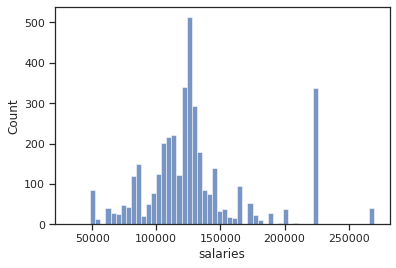

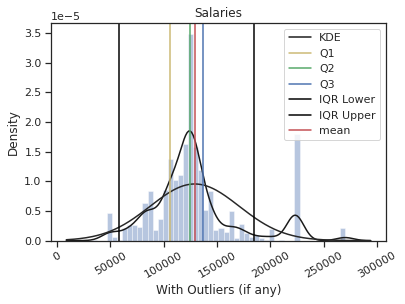

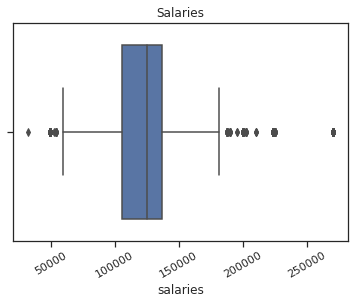

There are 447 records below and 99 above.
Records Including Outliers: 8327
Records Without Outliers: 3395


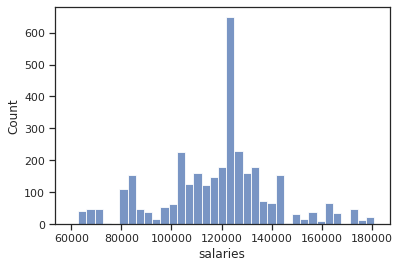

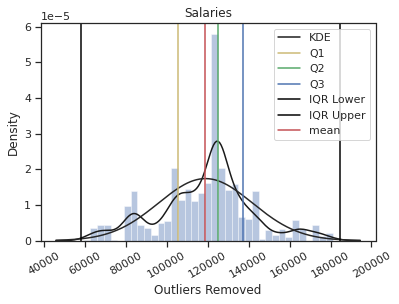

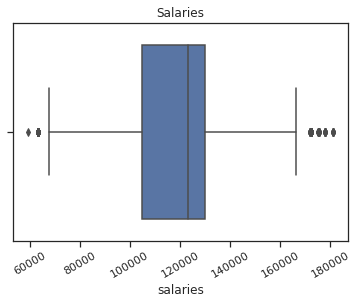

In [470]:
data, q1, q3= iqr_detect(data, feature='salaries')


## 4.1 Target
Before I can begin splitting the data I need to set the target for my methodology of training four seperate logistic regression models. I'm doing this because I'd like my classifications to be as accurate as possible, and also, by building my NLP strategy around a particular label, i.e. finding common words for that label as opposed to being generalized through the entire corpus\

I'm going to one-hot-encode the target feature so I can select each of the next columns as my y - one for each model.



##
I need to make one model for each target. Before doing so, I'll need to use gridsearch to find the best hyperperamters.
Looping through each target, I set y to that specific single-column binary '(for target in targets target == 0 or 1)'
Then do a test train split before setting up the pipeline. The grid being use in this case is the selection of hyperperamters I want to check.


In [471]:
def Q(row):
    """
    Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """
    q1 = np.quantile(data[data.salaries.notna()].salaries, 0.25)
    q2 = np.quantile(data[data.salaries.notna()].salaries, 0.5)
    q3 = np.quantile(data[data.salaries.notna()].salaries, 0.75)


    
    salary = row['salaries']
    if salary != np.nan:
        if salary < q1:
            row['Q1'] = 1
            row['target'] = 1

        if (salary >= q1) & (salary < q2):
            row['Q2'] = 1
            row['target'] = 2


        if (salary >= q2) & (salary < q3):
            row['Q3'] = 1
            row['target'] = 3


        if salary >= q3:
            row['Q4'] = 1
            row['target'] = 4

        if row['target'] == 0:
            row['target'] = np.nan
    
    return row



data['Q1'] = 0
data['Q2'] = 0
data['Q3'] = 0
data['Q4'] = 0
data['target'] = 0



data = data.apply( lambda row : Q(row), axis = 1)
for i,j in sorted(data.target.value_counts().items()):
    print(i,j)
data[data.salaries == 12000].salaries

1 740
2 946
3 798
4 911


Series([], Name: salaries, dtype: float64)

## EDA

### 2.2 Univariate Feature Analysis & Centering
I'm going to employ visual and statistical methods to analyze each feature, starting with the target, and outside of scaling, prepare them for logistic regression which will require that each feature's vaues are normally distributes.


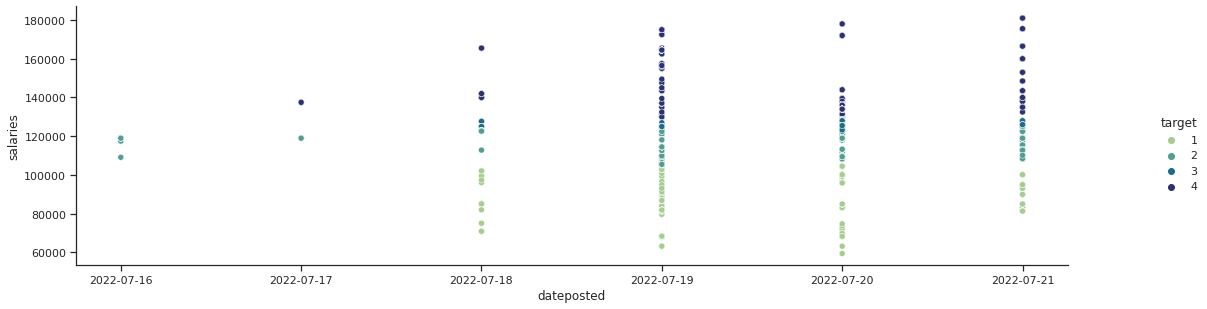

In [472]:
ax = sns.pairplot(data=data[data.salaries.notna()],
                  x_vars=['dateposted'],
                  y_vars=['salaries'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)

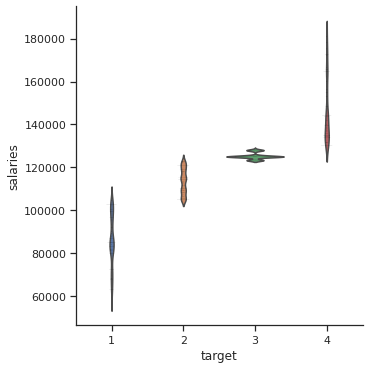

In [478]:

g = sns.catplot(x="target", y="salaries", kind="violin", inner=None, data=data)
sns.swarmplot(x="target", y="salaries", color="k", size=.1, data=data, ax=g.ax)
plt.show()

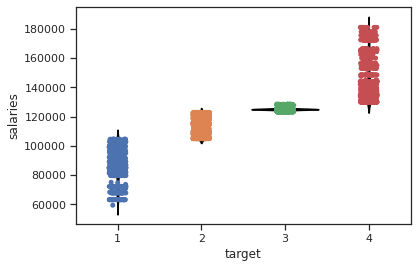

In [475]:
ax = sns.violinplot(x="target", y="salaries", data=data,

                    inner=None, color=".01")

ax = sns.stripplot(x="target", y="salaries", data=data)

In [480]:
ax = sns.boxplot(x="tip", y="day", data=data, whis=np.inf)

ax = sns.stripplot(x="tip", y="day", data=data, color=".3")

NameError: name 'tips' is not defined

In [476]:
for i in data[['Q1','Q2','Q3','Q4']]:
    print(data[i].value_counts())

0    2655
1     740
Name: Q1, dtype: int64
0    2449
1     946
Name: Q2, dtype: int64
0    2597
1     798
Name: Q3, dtype: int64
0    2484
1     911
Name: Q4, dtype: int64


In [ ]:
data = data[['company','job_title','state','city','rating','text', 'salaries', 'target', 'Q1', 'Q2', 'Q3', 'Q4']]

In [ ]:
# check for duplcates.
print(f'Number of dupes: {sum(data.duplicated())}')
data.drop_duplicates(inplace=True)
# check for missing
print(data.isna().sum().sort_values(ascending=False))
data.dropna(inplace = True)

print(f'Number of dupes: {sum(data.duplicated())}')
print(data.isna().sum().sort_values(ascending=False))


## Pipelining

In [ ]:

def grid_search_pipe():
    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    le_cols = ['company', 'job_title', 'state', 'city']
    scal_cols = ['rating']

    evaluations = {}

    
    for i in targets:
    # test/train split
        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)


        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'text'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', StandardScaler(), scal_cols)
                
                ],remainder='drop')
        #   populating parameter grid to search
        grid = [
            {
            'classifier' : [LogisticRegression()],
            #'classifier__penalty' : ['l1', 'l2'],
            #'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__solver' : ['liblinear']}
            ]

        pipe = Pipeline(
            steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(grid)),
            ],
            )


        
        grid_search = GridSearchCV(pipe, param_grid=grid, verbose=2, return_train_score=True)
        grid_search.fit(x_train,y_train)

        print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
        print(grid_search.best_params_)


        if i not in evaluations.keys():
            evaluations[i] = {
                'grid_search':grid_search,
                'x_train':x_train,
                'y_train':y_train,
                'x_test':x_test,
                'y_test':y_test
                
            }


    return evaluations


evaluations = grid_search_pipe()

## Modelling

In [ ]:
def make_model(evaluations):


    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    test_results = {}

    for i in targets:
        evaluation = evaluations[i]['grid_search']
        params = evaluation.best_params_


        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)



        le_cols = ['company', 'job_title', 'state', 'city']
        scal_cols = ['rating']

        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'text'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', MinMaxScaler(), scal_cols)
                
                ],remainder='drop')


        pipe = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', params['classifier']),
            ],
        )


        pipe.fit(x_train,y_train)

        predictions = pipe.predict(x_test)
        score = pipe.score(x_train, y_train)


        ### check
        check = pd.DataFrame(preprocessor.fit_transform(x_train,y_train).toarray())


        if i not in test_results.keys():
            test_results[i] = pipe, x_train, y_train, x_test, y_test, predictions, score
                
    return test_results, check
        
test_results, check = make_model(evaluations)


In [ ]:
def combinator(test_results):
    targets = ['Q1','Q2','Q3','Q4']

    resultsDB = {}
    lst = []

    
    for label in targets:
        data_dict = {}
        pipe = test_results[label][0]
        x_test = test_results[label][3]
        y_test = test_results[label][4]
        y_prob = pipe.predict_proba(x_test)
        predict_y = pipe.predict(x_test)
        data_dict = {
            f'{label}_y_test':y_test, 
             f'{label}_pred y': predict_y.tolist(),
             f'{label}_probabilities': y_prob.tolist()
             }
        zulu = x_test.join(pd.DataFrame(data_dict))
        if label not in resultsDB.keys():
            resultsDB[label] = zulu
        else:
            continue


        out = pd.DataFrame(data_dict)
        lst.append(out)

    results_table = x_test
    for i, label in zip(lst, targets):
        results_table = results_table.join(i, lsuffix=label)
    #results_table = results_table.join(lst[1], lsuffix='__')
    #for label, results in zip(targets,lst):
    #    results_table = results_table.join(results, lsuffix=label)
    return resultsDB, results_table, lst
   

data_dict, results_table, lst = combinator(test_results)

In [ ]:
len(test_results['Q1'])

In [ ]:
pipe = test_results['Q1'][0]
x_train = test_results['Q1'][1]
y_train = test_results['Q1'][2]

x_test = test_results['Q1'][3]

y_test = test_results['Q1'][4]

predictions =  test_results['Q1'][5]

score =  test_results['Q1'][6]

score = pipe.score(x_train, y_train)

predictions = pipe.predict(x_test)

print("Accuracy :",accuracy_score(y_test, predictions))
print("Hamming loss ",hamming_loss(y_test,predictions))
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print("\nClassification Report")
print (classification_report(y_test, predictions))
pipe.score(x_train, y_train)
cf1 = confusion_matrix(y_test, predictions)
Q = ['Q1']
te_confusions = [cf1]
y_t = [y_test]
te_probs = [pipe.predict_proba(x_test)]
y_pred = [predictions]
y_test_preds = predictions
y_prob = [pipe.predict_proba(x_test)]
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['0', '1']))

import sklearn.metrics as metrics# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-.01, 1.])
plt.ylim([-.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

for title, cf, y_t, y_pred, y_prob in zip(Q, te_confusions, y_test, y_test_preds, te_probs):
    make_confusion_matrix(cf, title='\n'+title+' Confusion Matrix\n')

results_table

def Q(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """
    #np.argmax(row[['Q1_Prob', 'Q2_Prob','Q3_Prob','Q4_Prob']].values)
    Q1 = row['Q1_probabilities'][1]
    Q2 = row['Q2_probabilities'][1]
    Q3 = row['Q3_probabilities'][1]
    Q4 = row['Q4_probabilities'][1]
    lst = [Q1,Q2,Q3,Q4]
    # adding 1 so these correspond to the target names rather than 0 indexed.
    return int(lst.index(max(lst))+1)
    #next, check if that 


results_table['Q'] = results_table.apply( lambda row : Q(row), axis = 1)
results_table


In [ ]:
results_table.columns

In [ ]:

ohe = OneHotEncoder(sparse=False)
#results_table = results_table.join(pd.DataFrame(ohe.fit_transform(results_table[['Q']]), columns=['Q1','Q2','Q3','Q4']))

ohe = ohe.fit_transform(results_table[['Q']]).T

results_table['Q1'] = ohe[0]
results_table['Q2'] = ohe[1]
results_table['Q3'] = ohe[2]
results_table['Q4'] = ohe[3]

results_table
results_table.columns
results_table.to_csv(f'../app/data/tableau_table.csv', index=False)
results_table=results_table[results_table.salaries.notna()]
results_table[results_table.Q != results_table.target]

results_table.info()


q1 = np.quantile(results_table.salaries, 0.25)
q2 = np.quantile(results_table.salaries, 0.5)
q3 = np.quantile(results_table.salaries, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(results_table.salaries)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

results_table.Q.value_counts()

g = sns.catplot(x="Q", y="salaries", kind="violin", inner=None, data=results_table)
sns.swarmplot(x="Q", y="salaries", color="k", size=2, data=results_table, ax=g.ax)

plt.xticks(rotation=0)

plt.show()

## EDA Stuff

In [ ]:
data2 = data.copy()
data2.dropna(inplace=True)


target = 'target'

associated = []

for i in data2.select_dtypes('number').columns:
    if i == target:
        continue
    else:
        pearson_cor, pval = pearsonr(data2[i],data2[target])

    if pearson_cor > .3:
        associated.append([i,pearson_cor])

# Extracting column names of the dependent variables that passed the pearson correlation test of being at least .3
num_cols = []
for i in associated:
    num_cols.append(i[0])
num_cols

In [ ]:
#TODO complete this by collecting the most significant colinear features and possibl removing them.

score_dictionary = {}
for i in data.select_dtypes('object').columns:
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    score_dictionary[i] = round(chi2,2)
score_df = pd.DataFrame(score_dictionary.items(), columns=['feature','chi2 score']).sort_values('chi2 score', ascending=False)
score_df[:-1]

## NLP Stuff

In [ ]:

X_tfidf = tfidf.fit_transform(_test).toarray()
vocab = q1_vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)

tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]

df_tfidf['top10']


In [ ]:
null = sum(data.salaries.isnull())
nnull = sum(data.salaries.notnull())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.')
#\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')


data[data['salaries'].notna()].salaries
print(missing(data, feature = 'salaries'))

'job_type_items'\
    I'm going to treat these as likert values, converrting each of these string formatted lists into an ordinal values for a new column.


In [ ]:
print(missing(data, feature = 'job_type_items'))

In [ ]:


TODO

Fri - Sat - Sun
- make sure shit has zeros
- check if there is missing salary data from dropped columns
------ clean: company, description, location, summary, job_title
------ split location
------ join main text
- prepare main text for nlp

- drop cols and do eda

- gridsearch
- model
- evaluation
- collate all data
- find class characteristics, i.e. top employers/locations/words-phrases

- Code review and organizing
- readme


Monday
- plots
- review kmeans
- review indeed
- review the best 2-3 other projects
- categorical features

NEXT
- Code Condensing
- Code Review
- Code Organization
- ReadMe
- EDA




Tuesday
- review remaining projects
- categorical features (wrap up)
- numeric features
- 2hrs linear alg
- 2hrs stats
- 2hrs proba


Wednesday
- review all projects, particularly text/readmes
- review resume
- 2hrs Git: commits and prettify
- LinkedIn
- Job Sites
- 1hr linear alg
- 1hr stats
- 1hr proba
- look at jobs/need for CVs


Thurs
- 2hr SQL
- 1hr Numpy
- 1hr Pandas
- 1hr SciPyStats
- 2hr quiz
- Apply


Days
- 1hr SQL
- 1hr Quiz and Practice Questions
- 1hr Projects
- 1hr Reading/Watching Knoweledge


Off
- 2hr SQL
- 2hr Apply
- 3hr Projects
- 1hr Reading/Watching Knoweledge
- 2hr Quiz and Practice Questions
- 1hr linear alg or stats or proba





def jobtype(data):
    """Used for creating a new feature containing nominal values for the job type.

    Args:
        data (string): Values from the 'job_type_items' column.

    Returns:
        string: Extracted and simplified values for each category.
    """
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass

cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()



data['jobtype'] = data.job_type_items.apply(jobtype)

data['text'] = data.description+' '+data.summary
#TODO add requirements

cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']


data.text = data.text.replace(')',' ')



data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly


'company'\
There's presently 96 different companies - that's a ton of dimensions added to the data, and I've still got to add count vectorizer. I'll try label encoding these. In the future, shifting these into clusters might be useful.\
Other than that, this variable doesn't seem to need much - 

In [ ]:
data.company.value_counts()

'location'\
This feature holds a wealth of information: state, city/remote, and in some cases a zip code.
Zip codes seem to be a recent addition to the information I can get from Indeed.com but since its presence is rather sparse I'll just extract city/remote and state values, splitting them into their respective columns.

In [ ]:
data.job_type_items.unique()

'job_title'\
Although the webscrapper searches for 'data scientist' the results contain over 80 unique job titles. This is largely due to a prefix or suffix that provides the role's specialization at that particular company for that particular job posting. These include items like 'Marketing', 'Senior', 'Geospatial...'.
I'll start by cleaning and simplifying these values, i.e. appearences of 'Sr' can be converted to 'Senior'. This will significantly reduce the number of unique values, hopefully increasing model accuracy.




In [ ]:
print(len(data.job_title.unique()))
data.job_title.unique()[:10]

'requirements'\
I will most likely merge this in with the description prior to conducting NLP. The rationale is that these explicit requirements may be echoed in the description or summary, so by adding them to the corpus I'll raise the scores derived from their increaseed frequency. Eventually I wiuld like to build a set of requirements that I can use in with a clustering algorithm, like KNN, to find/define subgroups within the sample population.

In [ ]:
data.requirements[0]

'summary'\
Much like the description, these are unique. COming from the search results page itself, these are brief descriptions of each job. In most cases this is not merely an abridgement of the summary. Like 'requirement' I'll start by lumping these texts in with description so analysis of the corpus can be boosted by the added descriptions.

In [ ]:
for i in data.summary[:3]:
    print(i)

'description'\
Each value is a unique string of the full job description. I'll lower and remove special characters but this feature will be dealt with seperately in its own NLP process.


'raw_desc_soup'\
I'm only saving this in case I refine or change my parsing. Below is a truncated slice of one of the raw records.

'url'\
Like raw_doc_soup, I'm simply keeping these in case I need to go back and re-parse the raw data. In fact, this URL points directly to the page where that raw doc soup is found.
I may also be able to detect job post updates and duplicates by using these unique addresses.

In [ ]:
data.raw_desc_soup[1][:1000]
data.url[0]

### 2.3 Wrangling & Feature Engineering
Below are the implementations of the data wrangling steps I described above for each feature. Using Numpy, Regex, and Pandas I'll simutaneaously clean the strings, extract and convert numeric information, and create new feature columns.

Let's see what the data looks like at this point. It looks like the 17 original features have been reduced to 11. Most of the columns have been collapsed and cleaned, too. Just a bit more work till this is ready for EDA, NLP, and transformations.

In [ ]:
data

In [ ]:


data.rating = data.rating.fillna(0)

cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

data['salary'] = data['salary'].apply(sal_fixer)

In [ ]:
data.salary

In [ ]:
data.columns
cols = ['salary','estimated_salary', 'job_type_items','raw_desc_soup', 'sal_guide_items','salary_and_jtype', 'salfromsection']
data.drop(cols,inplace=True,axis=1)
data.rename(columns={'final_sal': 'salary'},inplace=True)

data = data[data.description != 'NaN']

len(data)

data.description.value_counts()[1:]

### 2.4 Assessment

In [ ]:
data.info(memory_usage='deep')
data.head()

In [ ]:
shape = data.shape
print(f"The {shape[0]} rows of data now have {shape[1]} variables whose values are now cleaned and typed properly.\nThe only missing values are in Salary which is my target.\nNext, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .")
data.describe(include = 'all')


In [ ]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()

In [ ]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

In [ ]:
data = data[data['text'].notna()]

In [ ]:
data.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [ ]:
data

In [ ]:
munged = data
munged

In [ ]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

## EDA

In [ ]:
import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import pearsonr, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler



import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Target

### Numeric Features

#### 'dateposted'
This isn't going into the pipelie, despite some interesting patterns, I don't think there's enough periodic/seasonality information available here. Still, great for visualizing the job market.
### Categorical Features

#### 'job_title'
'job_title'\
Oddly enough, these number as many as company, I suspect multicolinearity. I'll come back to collapse these a bit and perhaps build a new feature for specializations out of these.
To be label encoded and possibly clustered later.

### Feature Associations
#### Feature Selection and Hyperparameter Tuning
### Pipeline GridSearch
## Modelling
## Evaluations

## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

In [ ]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.
Here we can see that there are five records with salary values outside the Z-score threshold.

To explore the possibility of outliers I'll start with a box and whisker plot. Those whisters reach 1.5 times past the IQR boundary on either side, and are generally provide a good means of identifying outliers - values beyond the boundaries.


A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

In [ ]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

In [ ]:
munged


#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.\
Here, I clearly demarcate the quartiles as well as the uppet and lower boundaries. Before removing these outliers let's take a look.

There aren't any outliers beyond the lower bound for either test so let's take a look at what's above the IQR threshold.\
While not guarenteed, its a good thing that both tests seem to identify the same five records, the salary values match.

Trimming the data, while showing the number of records were starting with and how many remain after removing the outliers viewed above.

In [ ]:
print(len(data))
data1 = data[data.salary <= iqr_upper]
data2 = data[data.salary.isnull()]
data = pd.concat([data1,data2])
print(len(data))
eda_data = data[data[col]>1]

In [ ]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
set(iqr_detect(munged))

In [ ]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

In [ ]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

In [ ]:
null = len(munged[munged.salary.isnull()])

nnull = len(munged[munged.salary.notnull()])

In [ ]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

In [ ]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [ ]:
munged.info()

In [ ]:
munged.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [ ]:
munged.info()

In [ ]:
munged.info(memory_usage='deep')

In [ ]:
munged.drop('location',inplace=True,axis=1)

In [ ]:
munged.info(memory_usage='deep')

In [ ]:
ax = sns.pairplot(data=data[data.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=10, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

In [ ]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()

In [ ]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

In [ ]:
sns.histplot(data,x='salary',bins=100)
plt.xticks(rotation=30)
plt.show()

In [ ]:
sns.violinplot(x="salary", data=data)
plt.xticks(rotation=30)
plt.show()

In [ ]:
sns.lineplot(x="dateposted", y="salary", hue="target", data=data)
plt.xticks(rotation=30)
plt.show()

In [ ]:
ax = sns.pairplot(data=data,
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)


